In [6]:
import pathlib
import sys

from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

sys.path.append(str(pathlib.Path("../..").resolve()))

from source.data import (
    create_splits,
    explode_multiple_locc,
    get_label_to_index_mapping,
)
from source.files import get_book_text, get_book_text_full, preprocess_text_old
from source.metrics import calculate_flat_binary_metrics
from source.models.nbayes import (
    create_tfidf_naive_bayes_model,
    create_vectorizer_naive_bayes_model,
)

In [2]:
splits = create_splits(verbose=False)
X_train, X_test, y_train, y_test = splits

In [3]:
NUM_CHUNKS = 10
TOKENS_PER_CHUNK = 500

In [8]:
X_train_texts = [
    preprocess_text_old(get_book_text_full(str(num)))
    for num in tqdm(X_train["Etext Number"])
]
X_test_texts = [
    preprocess_text_old(get_book_text_full(str(num)))
    for num in tqdm(X_test["Etext Number"])
]

KeyboardInterrupt: 

In [5]:
labels, lti, itl = get_label_to_index_mapping(splits)

mlb = MultiLabelBinarizer(classes=labels)
y_train_binarized = mlb.fit_transform([explode_multiple_locc(locc) for locc in y_train])
y_test_binarized = mlb.transform([explode_multiple_locc(locc) for locc in y_test])

/Users/oleksandr/me/repos/university/diploma/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['A'] will be ignored
  warnings.warn(


In [6]:
models = {
    "vectorizer": lambda: create_vectorizer_naive_bayes_model(),
    "tfidf": lambda: create_tfidf_naive_bayes_model(),
}

In [7]:
model_name = "vectorizer"
model = models[model_name]()

In [8]:
model.fit(X_train_texts, y_train_binarized)

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier',
                 MultiOutputClassifier(estimator=MultinomialNB()))])

In [9]:
y_pred_binarized = model.predict(X_test_texts)

              precision    recall  f1-score   support

          AP       0.65      0.17      0.27       693
           B       0.61      0.81      0.70      1190
           D       0.69      0.78      0.73      2920
          DI       0.66      0.71      0.68      1189
           O       0.55      0.65      0.59      1803
           P       0.85      0.88      0.86      6657
          PR       0.47      0.72      0.57      1789
          PS       0.39      0.75      0.52      1777
          PZ       0.46      0.84      0.60      1773
           Q       0.48      0.77      0.59       679

   micro avg       0.61      0.77      0.68     20470
   macro avg       0.58      0.71      0.61     20470
weighted avg       0.65      0.77      0.69     20470
 samples avg       0.60      0.75      0.64     20470


Multilabel Confusion Matrices (one for each label):


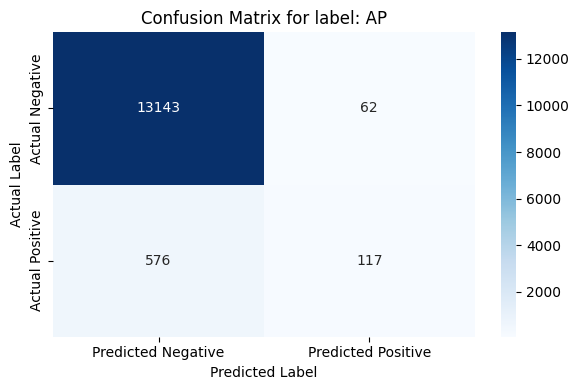

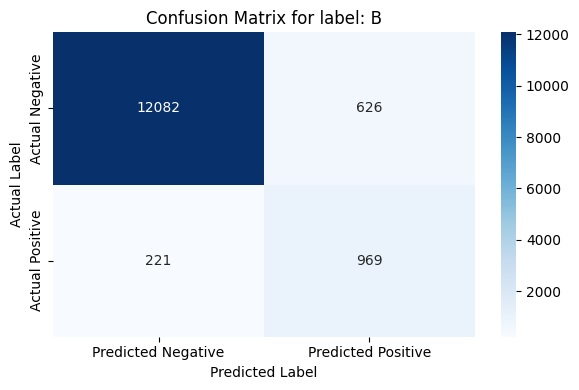

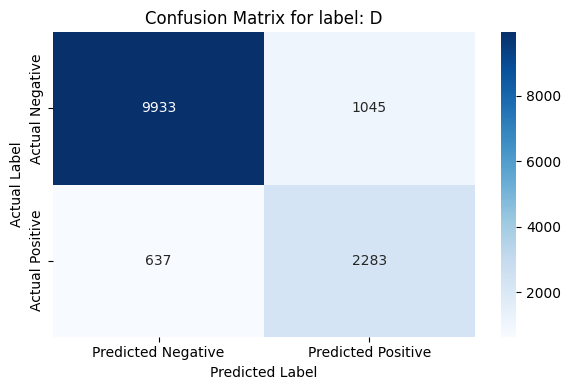

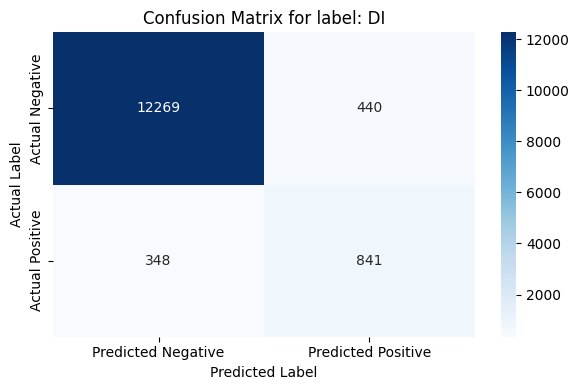

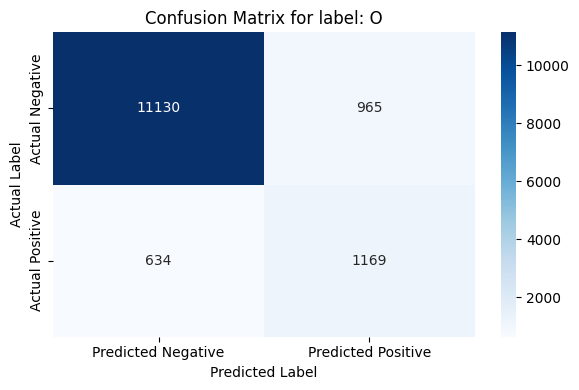

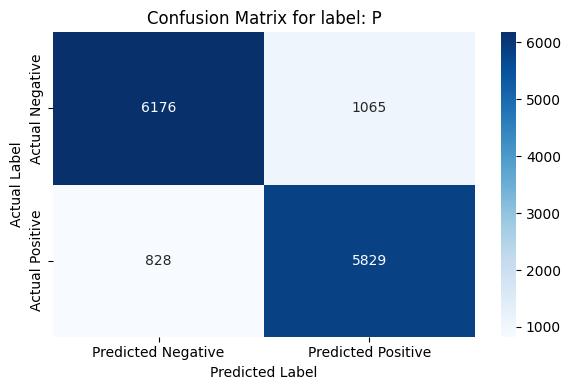

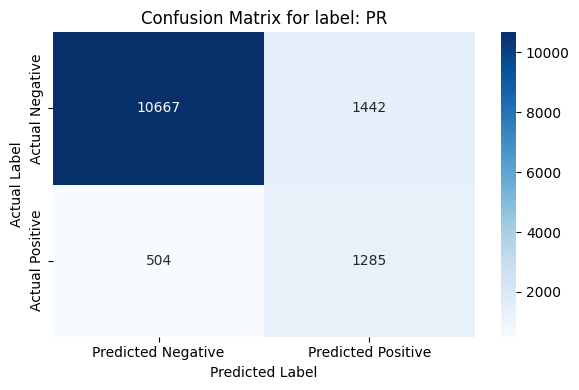

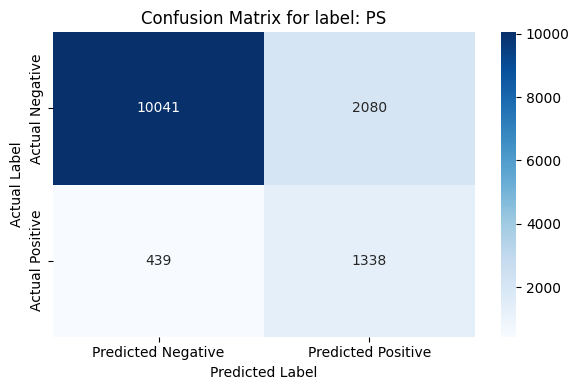

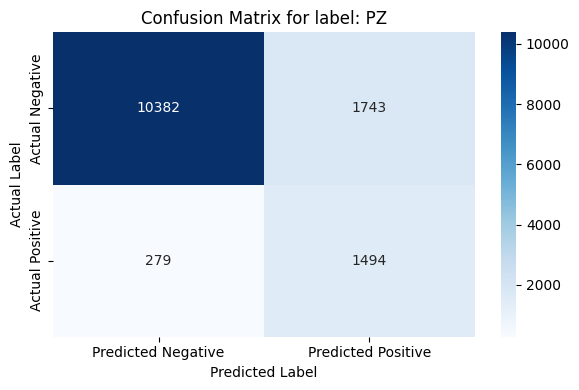

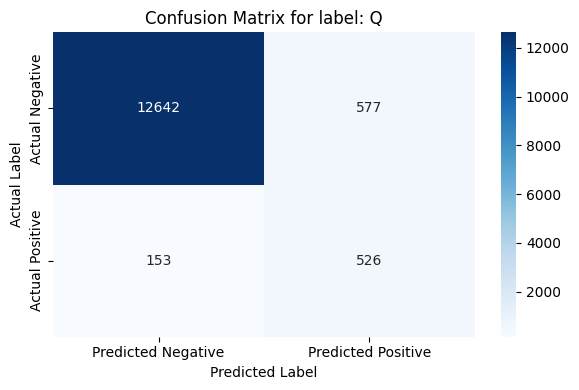

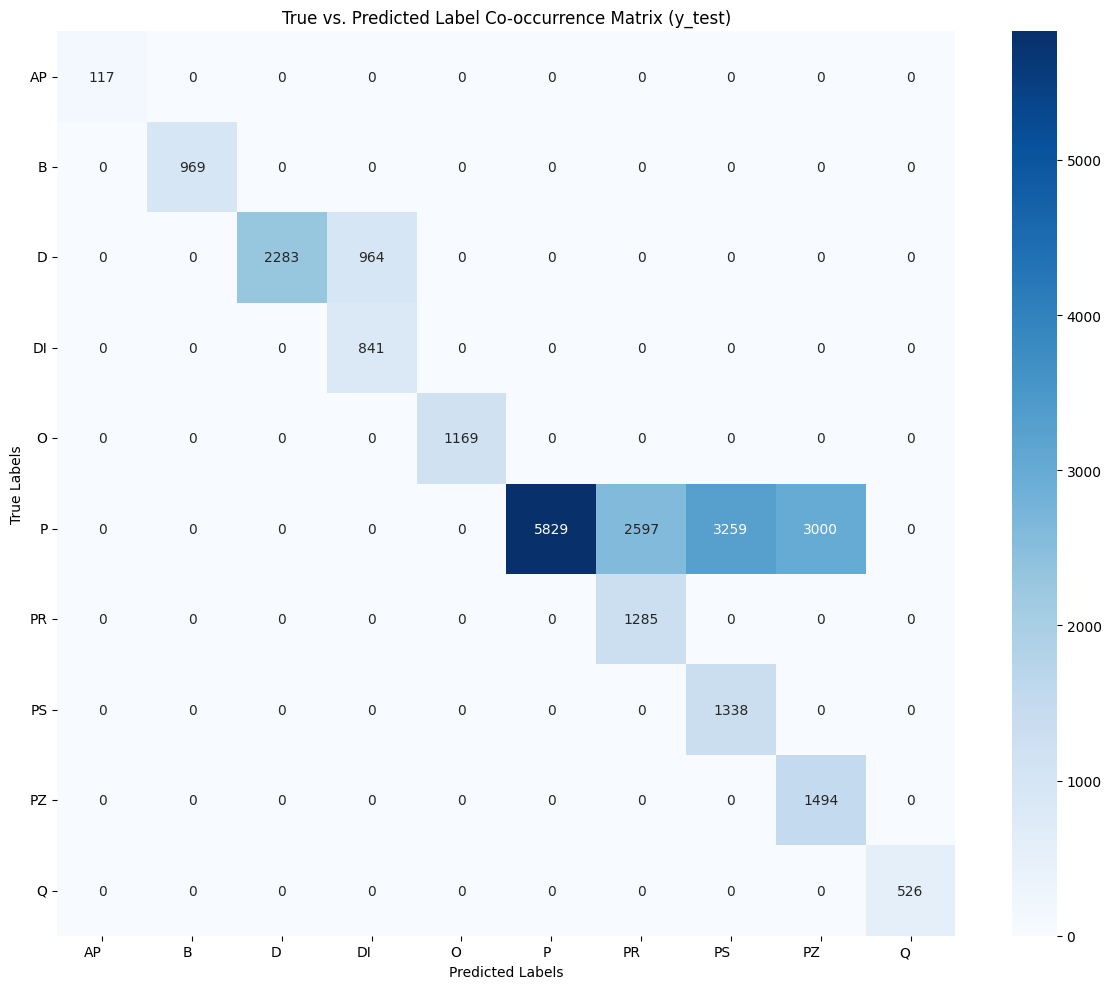

'/Users/oleksandr/me/repos/university/diploma/metrics/nbayes/vectorizer_4b8e43f1bd58cfe525347ab804a3b4b4'

In [10]:
calculate_flat_binary_metrics(
    y_test_binarized,
    y_pred_binarized,
    labels,
    "nbayes",
    model_name,
    hyperparams={"num_chunks": NUM_CHUNKS, "tokens_per_chunk": TOKENS_PER_CHUNK},
    save=True,
)